# Test finding conserved quantities in Neumann model - traj2circle

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt
from IPython import display

from models import *
from hamiltonians import parameterized_neumann
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

DTYPE=tf.float32
NP_DTYPE=np.float32


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
tf.set_random_seed(0)

In [3]:
sess = tf.InteractiveSession()

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Settings

In [16]:
frequencies = [.1, .2, .3]
settings = {
    'frequencies': frequencies,
    'hamiltonian': parameterized_neumann(frequencies),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'dataset_size': 2**13,      # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/neumann-traj/",
    'ckpt_freq': 1000,
    'train_iters': 2,
    'visualize': True,
#    'grad_clip_norm': 1e-10, # clip norm to val. Comment for no gradient clipping
    'starter_learning_rate': 0.00001,    
    'decay_lr': "piecewise",
    'boundaries': [20000, 100000, 200000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5, 1e-6],  # for piecewise decay
    'min_learning_rate': 1e-6   
#     'decay_steps': 25000,  # ignored if decay_lr False
#     'decay_rate': 0.5,     # ignored if decay_lr False (decayed_learning_rate = learning_rate *
#                            #                            decay_rate ^ (global_step / decay_steps))
#    'loss': "dKdphi",
#    'base_dist': "action_dirac_angle",
#    'value_actions': [0.1324, 0.0312, 0.2925],
#    'elastic_net_coeff': 1.
    }
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
# r = np.random.RandomState(seed=0)
# num_samples_actions = 2 # number of distinct actions (Liouville torii)
# sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
# settings['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
# print(settings['value_actions'])

## Trajectories

In [6]:
batch = 1
x0 = np.reshape([1,.1,2,.2,3,.3], (1, settings['d'], settings['num_particles'], 2)).astype(NP_DTYPE)
q0,p0 = extract_q_p(x0)
print("q0 = ", np.reshape(q0,[-1]))
print("p0 = ", np.reshape(p0,[-1]))
print("E  = ", sess.run( settings['hamiltonian'](tf.constant(x0)) ))

q0 =  [1. 2. 3.]
p0 =  [0.1 0.2 0.3]
E  =  1.8000001


In [7]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=settings['minibatch_size'])
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (num_time_samples,batch,d,n,2). Reinterpret batch and num_time_samples as batch
print(traj.shape)
#traj = np.reshape(traj, [-1,settings['d'],settings['num_particles'],2])
qtraj, ptraj = extract_q_p( np.reshape(traj, [-1,settings['d'],settings['num_particles'],2]) )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(128, 1, 3, 1, 2)


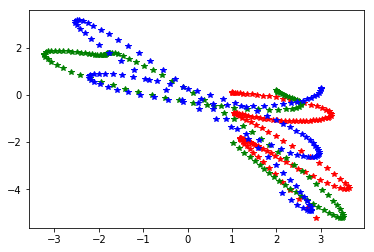

In [8]:
# orbits
cols=['r','g','b']
for n in range(settings['d']):
    plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], cols[n]+'*')
#plt.gca().set_aspect('equal', adjustable='box')

## Define the model and loss

Define the model T as sequence of symplectic transformations 

In [9]:
# No oscillator flow, map directly to phat,qhat cartesian coords of action-angle
stack = []
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ #ZeroCenter(is_training_forward=True),
                  LinearSymplectic(),
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
                  #SymplecticAdditiveCoupling(shift_model=MLP())])
T = Chain(stack)

Data, loss and train op:

The loss imposes that the trajectories in the transformed coordinates $\hat{q},\hat{p}$ are on circles of radius given by the actions. We choose the following one which makes couples of points have the same radius ($s$ is the shift and $t$ runs along time steps):
$$
\ell = \sum_d \sum_n \sum_{t=0}^{T-1} 
\left[\hat{q}(t,d,n)^2+\hat{p}(t,d,n)^2 - (\hat{q}(t-s,d,n)^2+\hat{p}(t-s,d,n)^2)\right]^2
$$

We can also take random shifts each time the loss is computed, which can be implemented as shuffling the data with a permutation $\pi$:
$$
\ell = \sum_d \sum_n \sum_{t=0}^{T-1} 
\left[\hat{q}(\pi(t),d,n)^2+\hat{p}(\pi(t),d,n)^2 - (\hat{q}(\pi(t-s),d,n)^2+\hat{p}(\pi(t-s),d,n)^2)\right]^2
$$
This can be achieved by shuffling data at each iteration using the data loading.

In [10]:
def make_circle_loss(z, shift=-1):
    zsq = tf.square(z)
    qhatsq, phatsq = extract_q_p(zsq)    
#     if settings['visualize']:
#         tf.summary.histogram("qhatsq", qhatsq)
#         tf.summary.histogram("phatsq", phatsq)

    diff_qhatsq = qhatsq - tf.roll(qhatsq, shift=shift, axis=0)
    diff_phatsq = phatsq - tf.roll(phatsq, shift=shift, axis=0)
    
#    return tf.reduce_mean(tf.square(diff_qhatsq + diff_phatsq))
    return tf.reduce_sum(tf.square(diff_qhatsq + diff_phatsq))

In [11]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

traj = tf.constant(traj, dtype=DTYPE)

# shuffle data along time dim - 0th axis
# TODO: use data loader
traj = tf.random_shuffle(traj)

from utils import extract_q_p
with tf.name_scope("canonical_transformation"):
    # traj is (num_time_samples,batch,d,n,2)
    num_time_samples = traj.shape[0]
    batch = traj.shape[1]    
    traj = tf.reshape(traj, [num_time_samples*batch,settings['d'],settings['num_particles'],2]) 
    z = T.inverse(traj)

    loss = make_circle_loss(z,shift=-settings['minibatch_size']//2)
    
    tf.summary.scalar('loss', loss)
    
train_op = make_train_op(settings, loss, step)

## Train

In [12]:
sess.run(tf.global_variables_initializer())

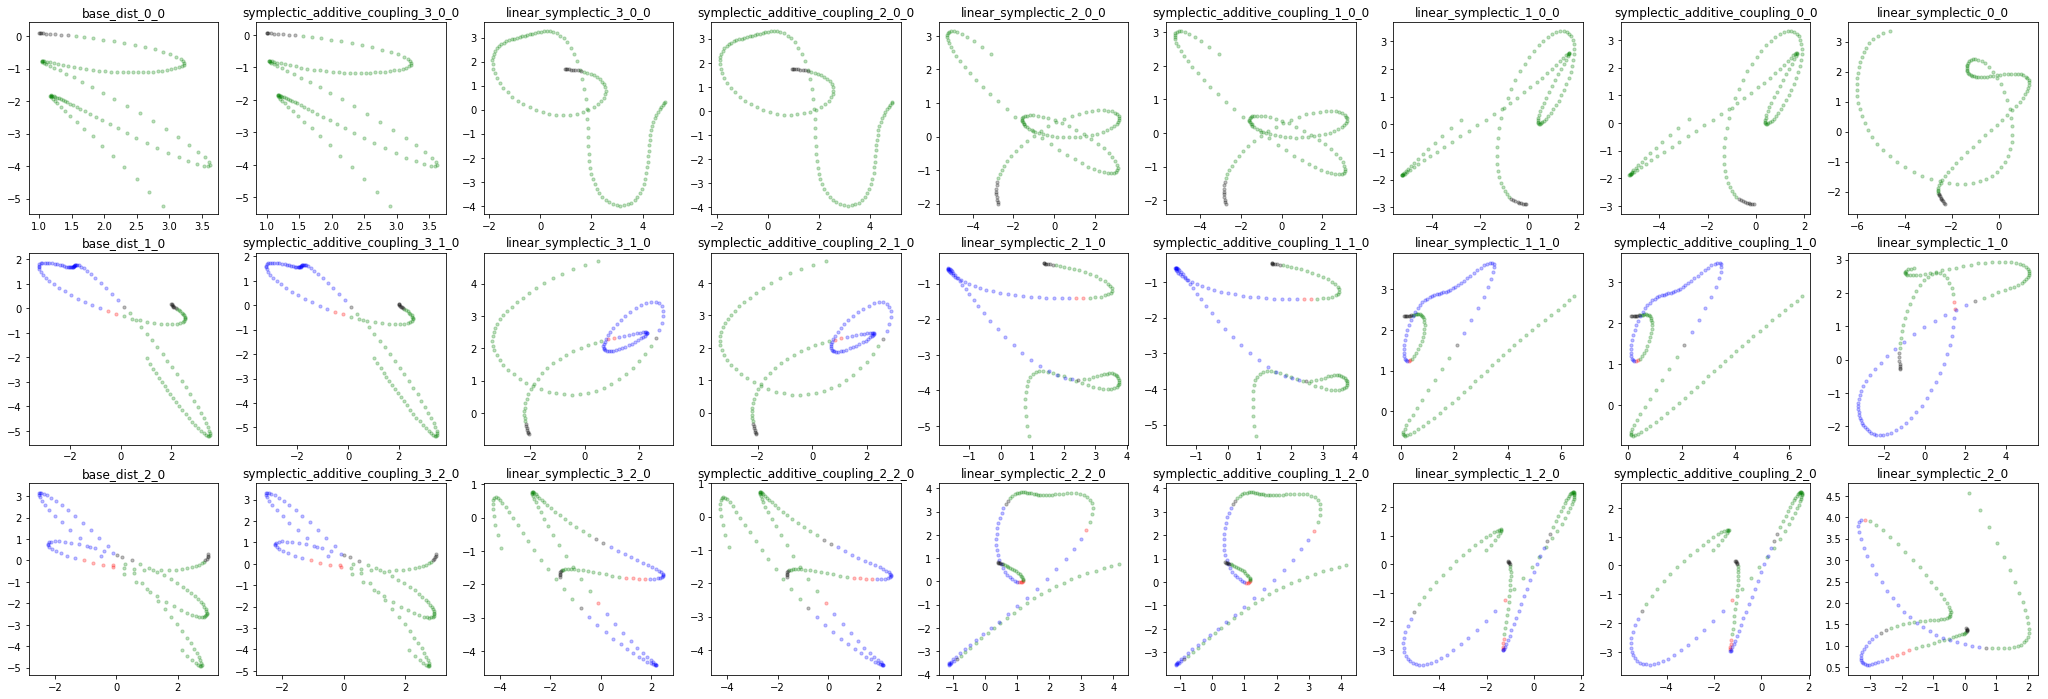

In [13]:
visualize_chain_bijector(T, traj, sess=sess, inverse=True)

In [13]:
losses = []
# Coordinates to monitor
dd = 0; nn = 0
loss_np = 1 # Init
loss_converged = 5e-7

In [14]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(settings['log_dir'], sess.graph)
checkpoint_dir = settings['log_dir']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
saver = tf.train.Saver(max_to_keep=2)

Loss at 119000 is 0.038069844245910645


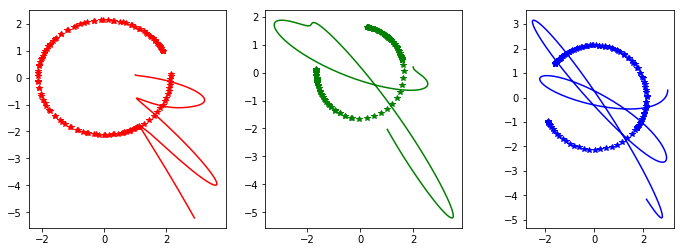

KeyboardInterrupt: 

In [17]:
while loss_np > loss_converged:
    _, summary, it, loss_np = sess.run([train_op, merged, step, loss])
    writer.add_summary(summary, it)
    losses.append(loss_np)
    
    if it % settings['ckpt_freq'] == 0:
        saver.save(sess, checkpoint_prefix, global_step=it) #, write_meta_graph=True)
        
    if it % 1000 == 0:        
        display.clear_output(wait=True)
        print("Loss at {} is {}".format(it, loss_np))
        fig = plt.figure(figsize=(12,4))
        qhat_traj,phat_traj = sess.run(extract_q_p(z))

        cols=['r','g','b']        
        for n in range(settings['d']):
            plt.subplot(1, settings['d'], n + 1)
            plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], cols[n]+'-')
            plt.plot(qhat_traj[:,n,0,0], phat_traj[:,n,0,0], cols[n]+'*')
        
        plt.gca().set_aspect('equal', adjustable='box')
        #plt.savefig('../results/kepler/image_at_it_{:04d}.png'.format(it))
        plt.show()

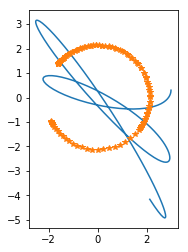

In [24]:
n = 2
plt.plot(qtraj[:,n,0,0], ptraj[:,n,0,0], '-')
plt.plot(qhat_traj[:,n,0,0], phat_traj[:,n,0,0], '*')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('../results/neumann_t2c.png')

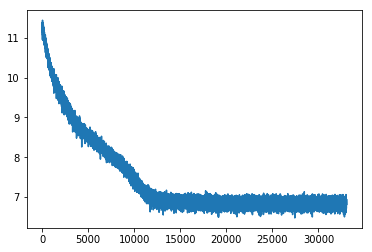

In [15]:
plt.plot(np.log(losses[:]))

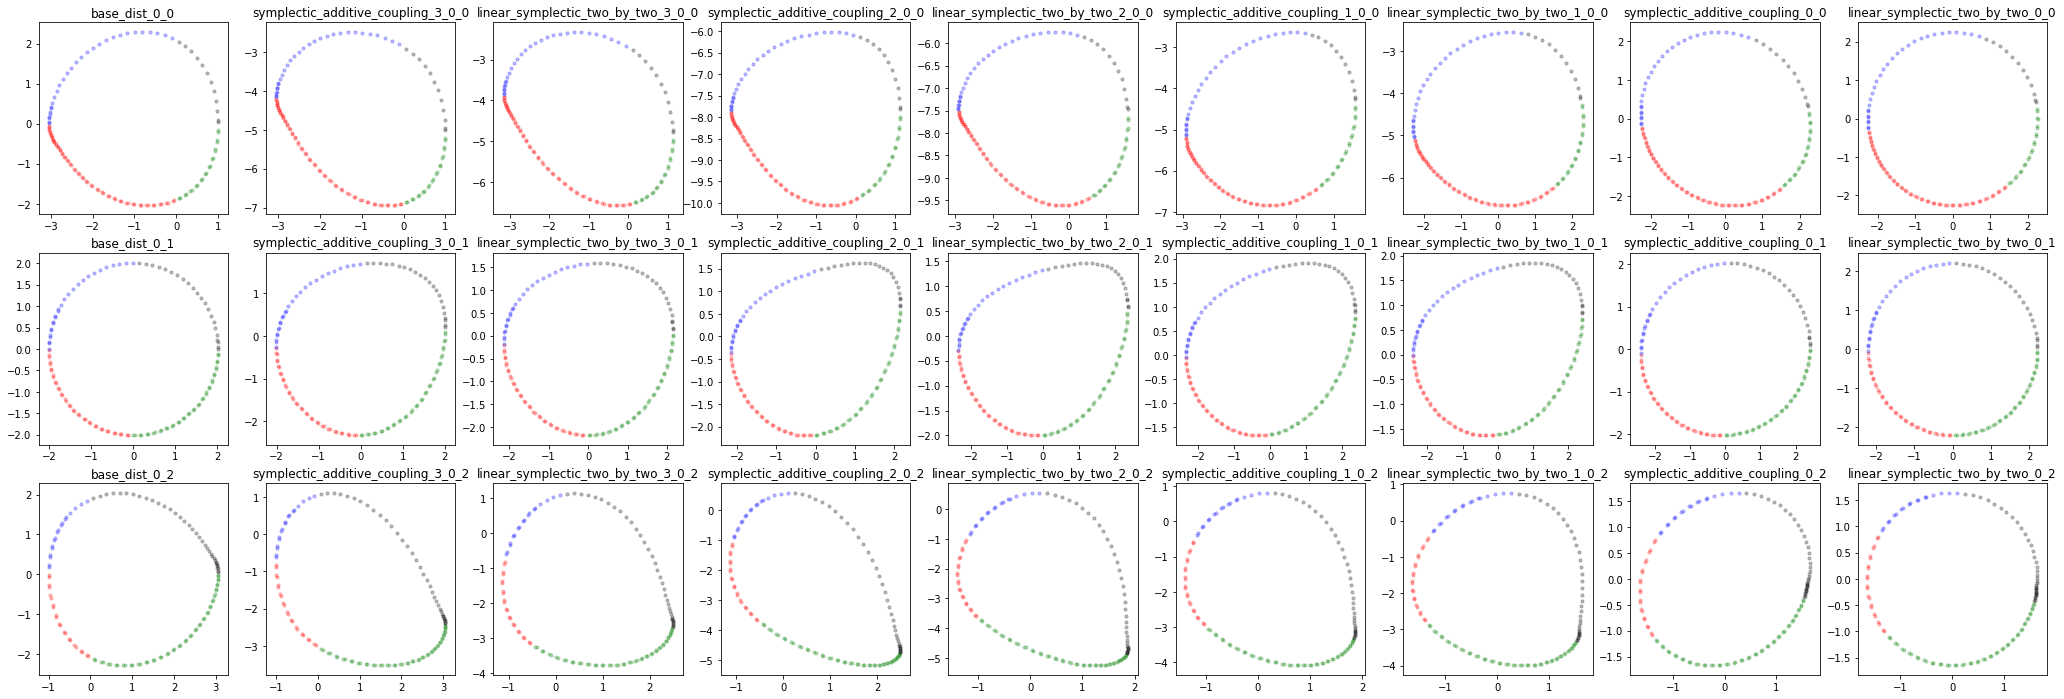

In [23]:
visualize_chain_bijector(T, traj, sess=sess, inverse=True)